In [100]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import scipy.spatial as sp
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

## Dataset

In [5]:
#create custom dataset class

class MyDataset(Dataset):  
    def __init__(self, data, target, transform=None, flatten=False):
        if flatten:
            data = np.reshape(data, [-1, 28*28])
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
    
        if self.transform:
            x = self.transform(x)      
        return x,y
  
    def __len__(self):
        return len(self.data)

## Networks

In [6]:
class Network(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        
        self.hidden = nn.Linear(784, n_hidden)
        self.output = nn.Linear(n_hidden, 10)
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x) 
        return x

In [133]:
class NetworkConv(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_hidden, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n_hidden, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(2592, 10)
        self.softmax = nn.Softmax(dim=1)
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 2592)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

## Diversification functions

In [129]:
# negative correlation for weights in layer

def div_nc(weights, gamma = 1): #pass layer weights and gamma parameter here
    tensor_sum = 0.0
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):      
        tensor_sum += weights[i]
        tensor_mean = tensor_sum/len(weights)
    
    for i in range(len(weights)):     
        tensor_sum_nc += torch.abs(torch.mean(((tensor_mean)**2 - (weights[i])**2)))
   
    loss = gamma*tensor_sum_nc    
    return loss

In [125]:
#cosine similarity diversification (each with each - quadratic O)

def div_cosine(weights, gamma = 1):  
    tensor_sum = torch.zeros([len(weights[0])])
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):
        for j in range(len(weights)):
            tensor_sum_nc += torch.mean(F.cosine_similarity(weights[i],
                                                            weights[j],
                                                            0))
    
    loss = gamma*tensor_sum_nc
    return loss

In [120]:
#cosine similarity diversification (each with mean - linear O)

def div_cosine_lin(weights, gamma = 1): #pass layer weights and gamma parameter here
    tensor_sum = 0.0
    tensor_sum_nc = 0.0
    
    for i in range(len(weights)):      
        tensor_sum += weights[i]
        tensor_mean = tensor_sum/len(weights)
    
    for i in range(len(weights)):     
        tensor_sum_nc += torch.mean(F.cosine_similarity(tensor_mean,
                                                        weights[i],
                                                        0))
   
    loss = gamma*tensor_sum_nc
    return loss

### Test functions

In [121]:
model = Network(16).to(device)

In [122]:
modelConv = NetworkConv(16).to(device)

In [131]:
#DNN test
print(div_cosine(model.hidden.weight))
print(div_cosine_lin(model.hidden.weight))
print(div_nc(model.hidden.weight))

tensor(16.2898, grad_fn=<MulBackward0>)
tensor(4.0353, grad_fn=<MulBackward0>)
tensor(0.0063, grad_fn=<MulBackward0>)


In [132]:
#CNN test
print(div_cosine(modelConv.conv2.weight))
print(div_cosine_lin(modelConv.conv2.weight))
print(div_nc(modelConv.conv2.weight))

tensor(35.5720, grad_fn=<MulBackward0>)
tensor(5.8617, grad_fn=<MulBackward0>)
tensor(0.0719, grad_fn=<MulBackward0>)


# Train NN

In [198]:
def train(model, device, train_loader, optimizer, epoch, layer, gamma=0.0, diversity = "nc"):
    model.train()
    train_loss = 0
    train_correct = 0
    # mean and standard deviation
    train_mean = 0
    train_std = 0
    #diversification and loss separately
    gamma_monitor = 0
    loss_monitor = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if diversity == 'nc':
            loss = criterion(output, target) + div_nc(layer, gamma)
        elif diversity == 'cosine':
            loss = criterion(output, target) + div_cosine(layer, gamma)
        elif diversity == 'cosine_lin':
            loss = criterion(output, target) + div_cosine(layer, gamma)
        elif diversity == 'none':
            loss = criterion(output, target)
            gamma = 1
        #loss = conv_nc_2(model.hidden.weight, gamma)
        #print(model.hidden.weight.mean()*1000)
        train_mean += model.hidden.weight.mean()
        train_std += model.hidden.weight.std()
        gamma_monitor += div_nc(model.hidden.weight, gamma)
        loss_monitor += criterion(output, target)
        #print(conv_nc(model.output.weight, gamma))
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_mean /= len(train_loader.dataset)
    train_std /= len(train_loader.dataset)
    gamma_monitor /= len(train_loader.dataset)
    loss_monitor /= len(train_loader.dataset)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset),
        100. * train_correct / len(train_loader.dataset)
        )
    )

    return 100. * train_correct / len(train_loader.dataset), train_mean, train_std, gamma_monitor, loss_monitor

In [177]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
        )
    )

    return 100. * correct / len(test_loader.dataset), test_loss

## Train DNN (Fashion MNIST)

In [161]:
#download dataset from another library (keras)
from keras.datasets import mnist
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [162]:
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))/255
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))/255

In [142]:
train_dataset = MyDataset(x_train, y_train, transform=None, flatten=True)
train_loader = DataLoader(train_dataset, batch_size = 4096*2, shuffle=True)

test_dataset = MyDataset(x_test, y_test, transform=None, flatten=True)
test_loader = DataLoader(test_dataset, batch_size = 4096*2, shuffle=False)

In [191]:
gammas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]#
ns = [16]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in gammas:

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 30
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 17833/60000 (30%)

Test set: Average loss: 0.0004, Accuracy: 4486/10000 (45%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 27583/60000 (46%)

Test set: Average loss: 0.0004, Accuracy: 4748/10000 (47%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 29390/60000 (49%)

Test set: Average loss: 0.0004, Accuracy: 5238/10000 (52%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 32759/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5568/10000 (56%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 33247/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5528/10000 (55%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 33387/60000 (56%)

Test set: Average loss: 0.0004, Accuracy: 5573/10000 (56%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 33631/60000 (56%)

Test set: Average loss: 0.0004, Accuracy: 5758/10000 (58%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy:


Train set: Average loss: 0.0003, Accuracy: 28859/60000 (48%)

Test set: Average loss: 0.0004, Accuracy: 4950/10000 (50%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 30749/60000 (51%)

Test set: Average loss: 0.0004, Accuracy: 5712/10000 (57%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 36726/60000 (61%)

Test set: Average loss: 0.0004, Accuracy: 6472/10000 (65%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 39826/60000 (66%)

Test set: Average loss: 0.0004, Accuracy: 6737/10000 (67%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 41065/60000 (68%)

Test set: Average loss: 0.0004, Accuracy: 6913/10000 (69%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 43350/60000 (72%)

Test set: Average loss: 0.0004, Accuracy: 7491/10000 (75%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy: 45868/60000 (76%)

Test set: Average loss: 0.0004, Accuracy: 7657/10000 (77%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 46608/60000


Train set: Average loss: 0.0003, Accuracy: 25026/60000 (42%)

Test set: Average loss: 0.0004, Accuracy: 5141/10000 (51%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 33732/60000 (56%)

Test set: Average loss: 0.0004, Accuracy: 6144/10000 (61%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 38106/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6422/10000 (64%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 38823/60000 (65%)

Test set: Average loss: 0.0004, Accuracy: 6497/10000 (65%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 39116/60000 (65%)

Test set: Average loss: 0.0004, Accuracy: 6577/10000 (66%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy: 39682/60000 (66%)

Test set: Average loss: 0.0004, Accuracy: 6771/10000 (68%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 41606/60000 (69%)

Test set: Average loss: 0.0004, Accuracy: 6930/10000 (69%)

Epoch #:  10

Train set: Average loss: 0.0002, Accuracy: 42197/6000

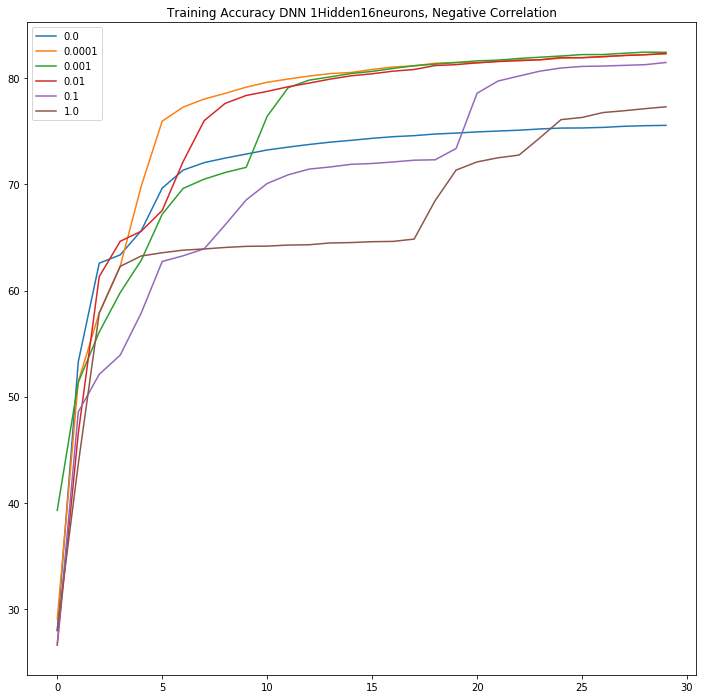

In [184]:
plt.figure(figsize=(12,12))
for tp in train_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Training Accuracy DNN 1Hidden16neurons, Negative Correlation')
plt.savefig('Training_Accuracy_DNN_1Hidden16neurons_Negative Correlation.png')

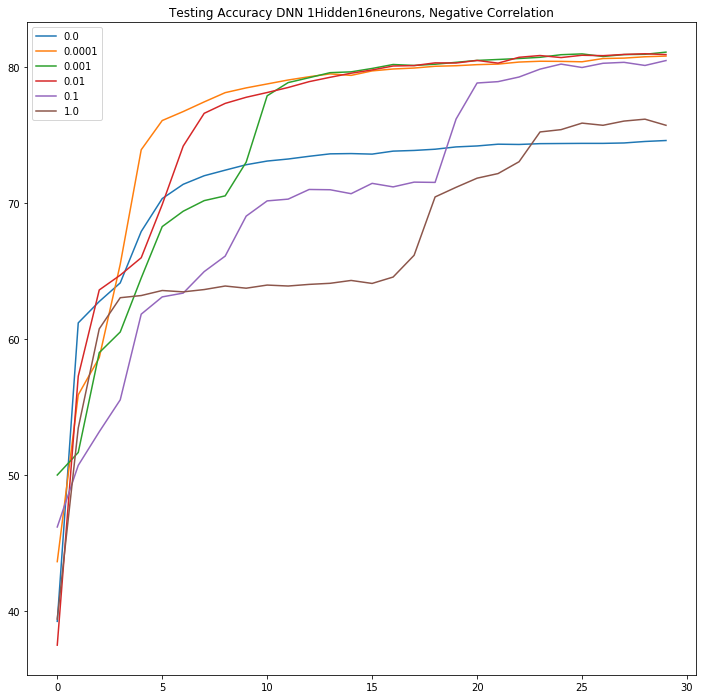

In [185]:
plt.figure(figsize=(12,12))
for tp in test_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Testing Accuracy DNN 1Hidden16neurons, Negative Correlation')
plt.savefig('Testing_Accuracy_DNN_1Hidden16neurons_Negative Correlation.png')

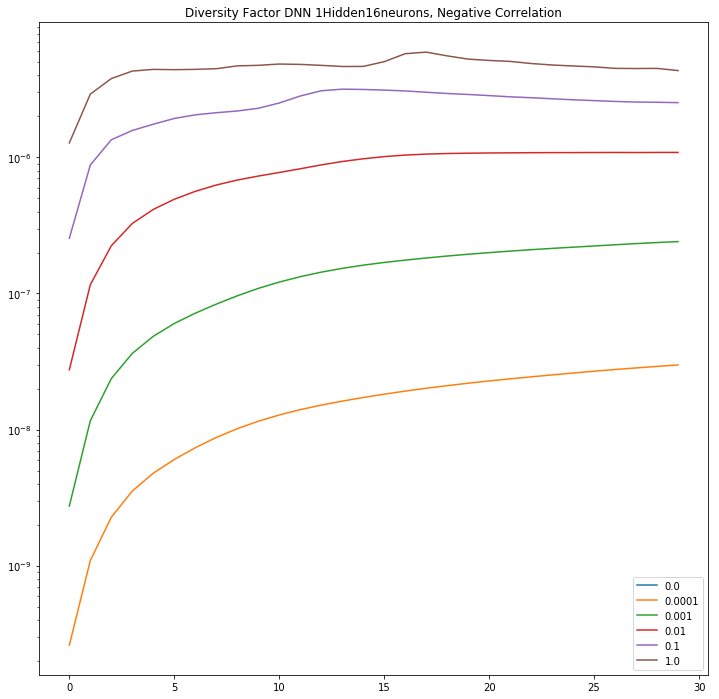

In [200]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in diversity[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Diversity Factor DNN 1Hidden16neurons, Negative Correlation')
plt.savefig('Diversity_Factor_DNN_1Hidden16neurons_Negative Correlation.png')
plt.yscale('log') #

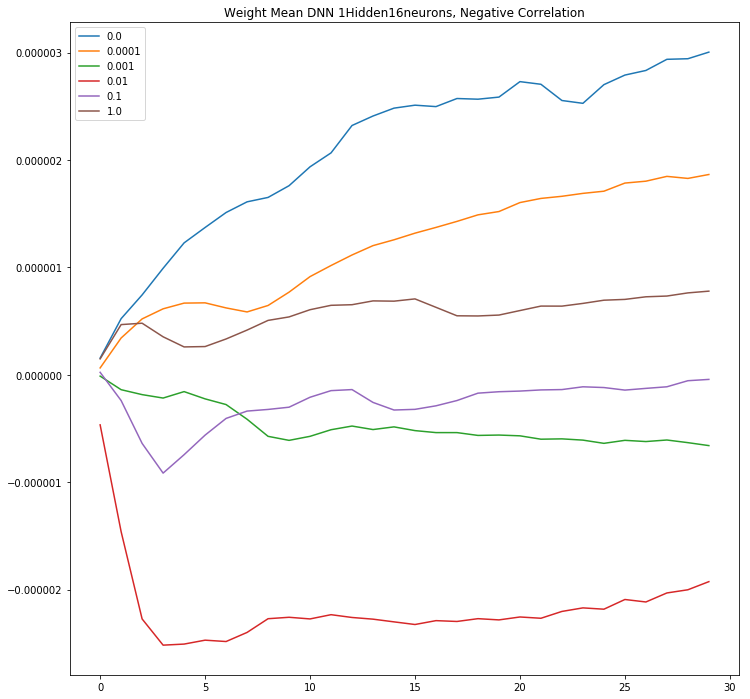

In [201]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in mean_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Weight Mean DNN 1Hidden16neurons, Negative Correlation')
plt.savefig('Weight_Mean_DNN_1Hidden16neurons_Negative Correlation.png')
#plt.yscale('log') #

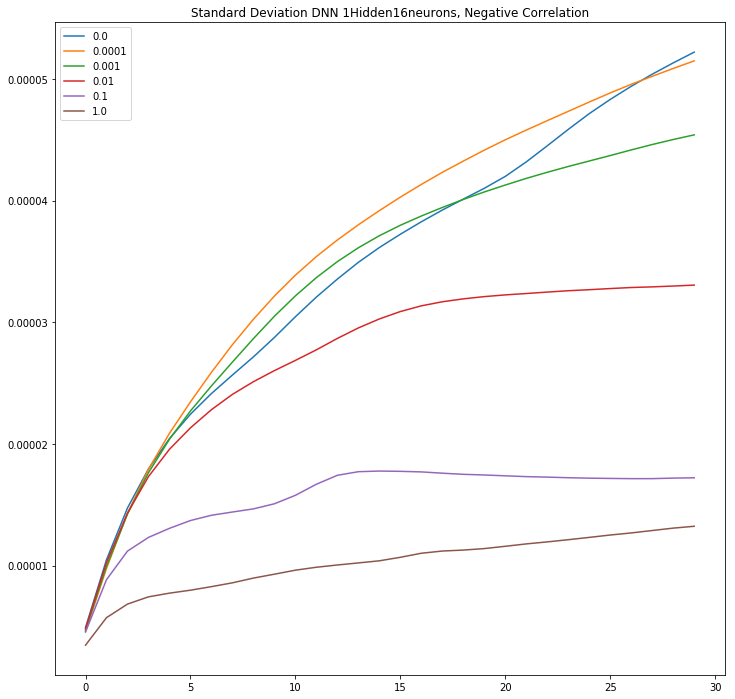

In [205]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in std_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Standard Deviation DNN 1Hidden16neurons, Negative Correlation')
plt.savefig('Standard_Deviation_DNN_1Hidden16neurons_Negative Correlation.png')
#plt.yscale('log') #

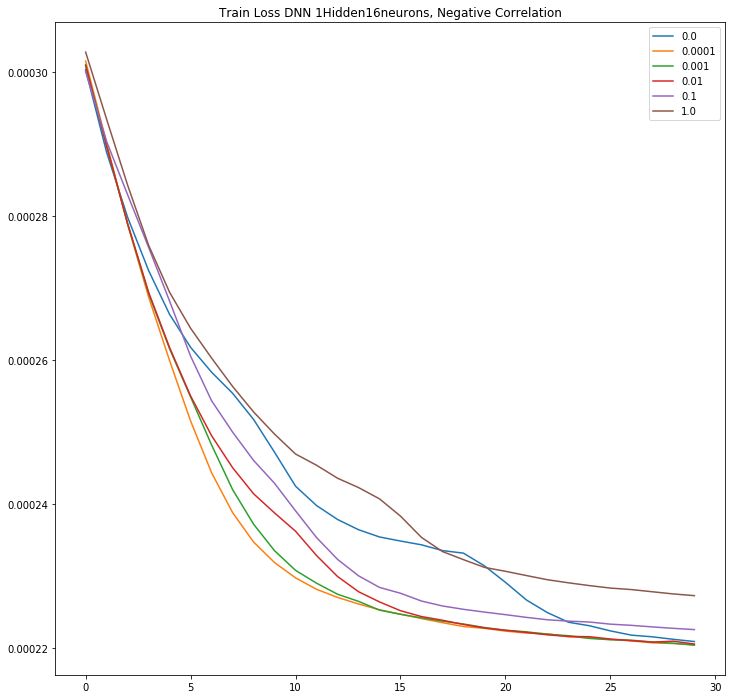

In [203]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_train_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Train Loss DNN 1Hidden16neurons, Negative Correlation')
plt.savefig('Train_Loss_DNN_1Hidden16neurons_Negative Correlation.png')
#plt.yscale('log') #

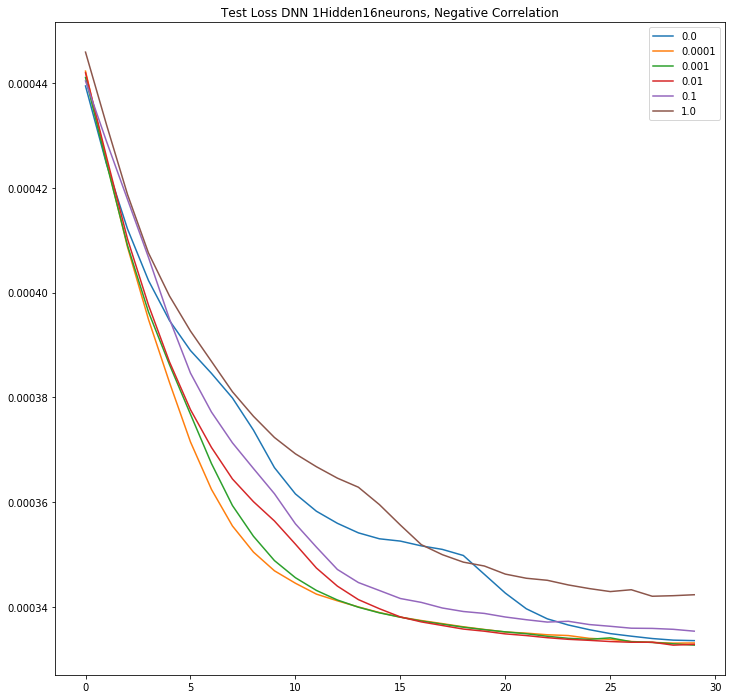

In [206]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.0001, 0.001, 0.01, 0.1, 1.0])
plt.title('Test Loss DNN 1Hidden16neurons, Negative Correlation')
plt.savefig('Test_Loss_DNN_1Hidden16neurons_Negative Correlation.png')
#plt.yscale('log') #

In [209]:
gammas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1]#
ns = [16]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in gammas:

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 30
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g,
                                            diversity='cosine'
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 16980/60000 (28%)

Test set: Average loss: 0.0004, Accuracy: 3134/10000 (31%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 22229/60000 (37%)

Test set: Average loss: 0.0004, Accuracy: 4412/10000 (44%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 28200/60000 (47%)

Test set: Average loss: 0.0004, Accuracy: 5152/10000 (52%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 33422/60000 (56%)

Test set: Average loss: 0.0004, Accuracy: 6146/10000 (61%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 37771/60000 (63%)

Test set: Average loss: 0.0004, Accuracy: 6583/10000 (66%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 40610/60000 (68%)

Test set: Average loss: 0.0004, Accuracy: 6930/10000 (69%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 42201/60000 (70%)

Test set: Average loss: 0.0004, Accuracy: 7027/10000 (70%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy:


Train set: Average loss: 0.0003, Accuracy: 26861/60000 (45%)

Test set: Average loss: 0.0004, Accuracy: 5204/10000 (52%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 33403/60000 (56%)

Test set: Average loss: 0.0004, Accuracy: 6085/10000 (61%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 37711/60000 (63%)

Test set: Average loss: 0.0004, Accuracy: 6472/10000 (65%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 39885/60000 (66%)

Test set: Average loss: 0.0004, Accuracy: 6714/10000 (67%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 41075/60000 (68%)

Test set: Average loss: 0.0004, Accuracy: 6842/10000 (68%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 41710/60000 (70%)

Test set: Average loss: 0.0004, Accuracy: 6904/10000 (69%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy: 42093/60000 (70%)

Test set: Average loss: 0.0004, Accuracy: 6969/10000 (70%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 42462/60000


Train set: Average loss: 0.0003, Accuracy: 18131/60000 (30%)

Test set: Average loss: 0.0004, Accuracy: 3302/10000 (33%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 21051/60000 (35%)

Test set: Average loss: 0.0004, Accuracy: 4114/10000 (41%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 26570/60000 (44%)

Test set: Average loss: 0.0004, Accuracy: 4619/10000 (46%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 29935/60000 (50%)

Test set: Average loss: 0.0004, Accuracy: 5442/10000 (54%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 33037/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5522/10000 (55%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy: 34038/60000 (57%)

Test set: Average loss: 0.0004, Accuracy: 6107/10000 (61%)

Epoch #:  9

Train set: Average loss: 0.0003, Accuracy: 37466/60000 (62%)

Test set: Average loss: 0.0004, Accuracy: 6255/10000 (63%)

Epoch #:  10

Train set: Average loss: 0.0003, Accuracy: 37832/6000

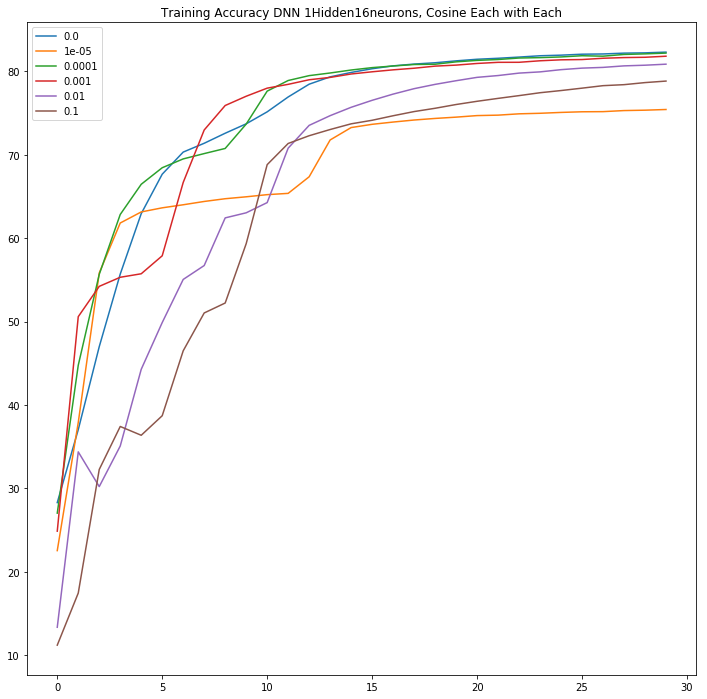

In [211]:
plt.figure(figsize=(12,12))
for tp in train_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Training Accuracy DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('Training_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')

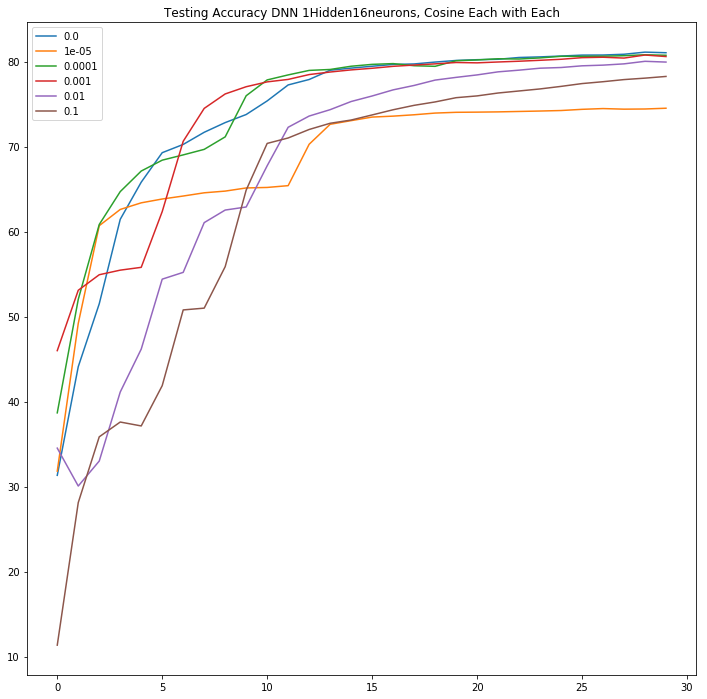

In [212]:
plt.figure(figsize=(12,12))
for tp in test_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Testing Accuracy DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('Testing_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')

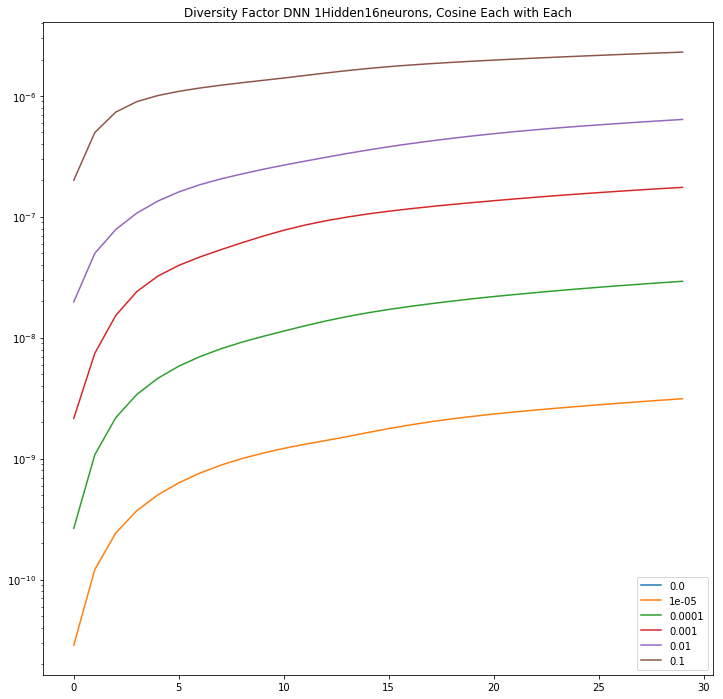

In [213]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in diversity[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Diversity Factor DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('Diversity_Factor_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
plt.yscale('log') #

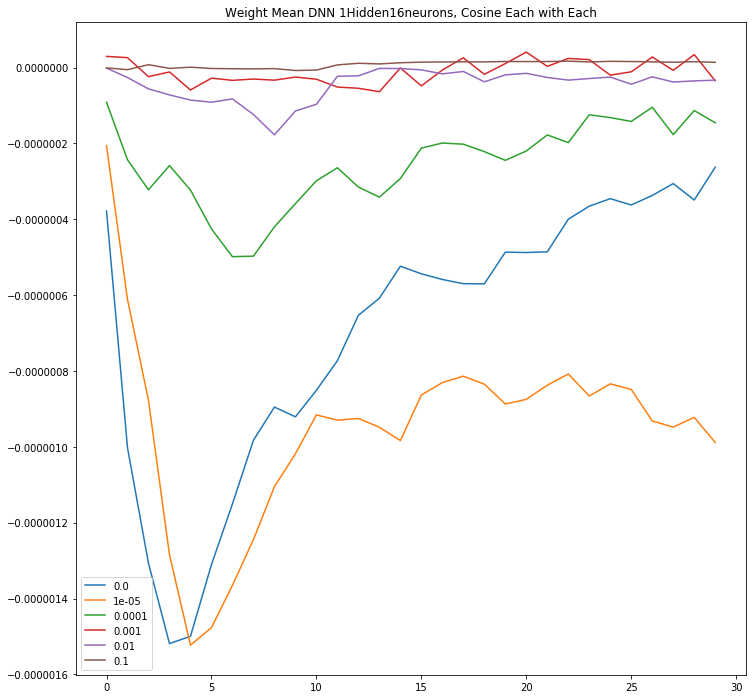

In [214]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in mean_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Weight Mean DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('Weight_Mean_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

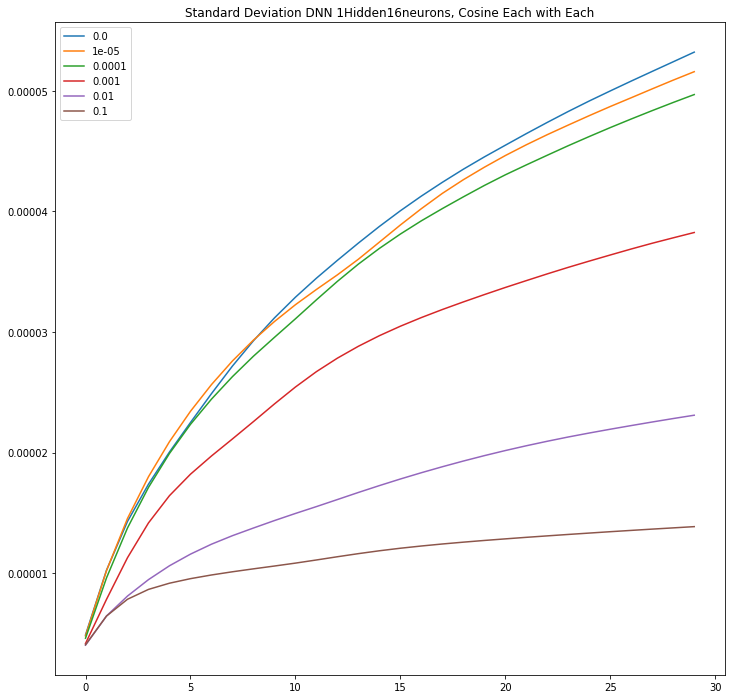

In [215]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in std_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Standard Deviation DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('Standard_Deviation_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

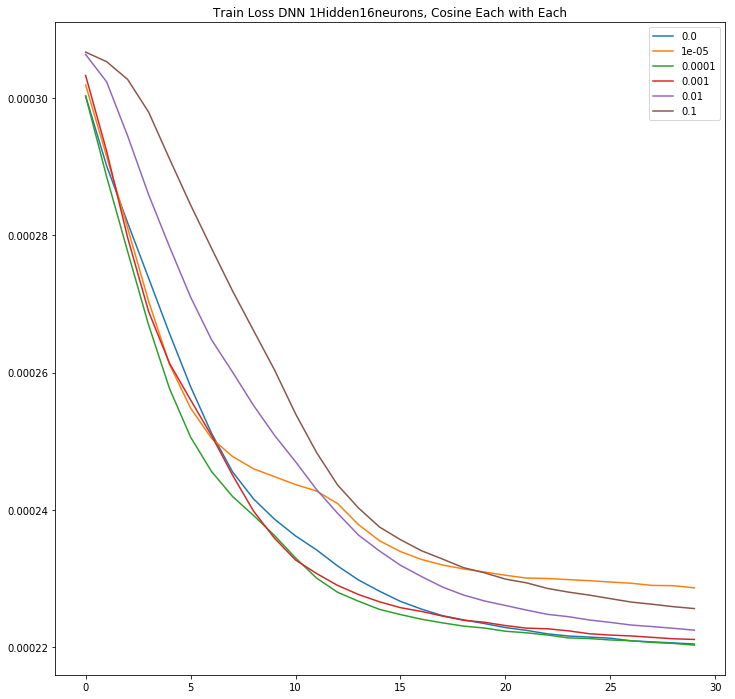

In [216]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_train_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Train Loss DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('Train_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

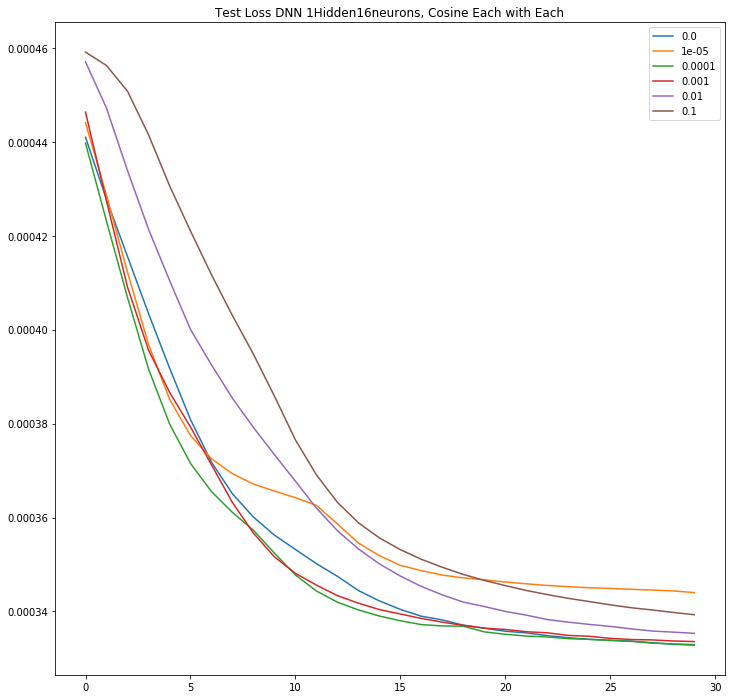

In [217]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Test Loss DNN 1Hidden16neurons, Cosine Each with Each')
plt.savefig('Test_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Each.png')
#plt.yscale('log') #

In [218]:
gammas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1]#
ns = [16]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in gammas:

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 30
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g,
                                            diversity='cosine_lin'
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 17600/60000 (29%)

Test set: Average loss: 0.0004, Accuracy: 4078/10000 (41%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 26478/60000 (44%)

Test set: Average loss: 0.0004, Accuracy: 4578/10000 (46%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 27940/60000 (47%)

Test set: Average loss: 0.0004, Accuracy: 4946/10000 (49%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 32067/60000 (53%)

Test set: Average loss: 0.0004, Accuracy: 5634/10000 (56%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 35968/60000 (60%)

Test set: Average loss: 0.0004, Accuracy: 6237/10000 (62%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 38009/60000 (63%)

Test set: Average loss: 0.0004, Accuracy: 6336/10000 (63%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 38295/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6384/10000 (64%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy:


Train set: Average loss: 0.0003, Accuracy: 32132/60000 (54%)

Test set: Average loss: 0.0004, Accuracy: 5740/10000 (57%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 35321/60000 (59%)

Test set: Average loss: 0.0004, Accuracy: 6062/10000 (61%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 37215/60000 (62%)

Test set: Average loss: 0.0004, Accuracy: 6265/10000 (63%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 38313/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6593/10000 (66%)

Epoch #:  6

Train set: Average loss: 0.0002, Accuracy: 41002/60000 (68%)

Test set: Average loss: 0.0004, Accuracy: 6995/10000 (70%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 42747/60000 (71%)

Test set: Average loss: 0.0004, Accuracy: 7131/10000 (71%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy: 43229/60000 (72%)

Test set: Average loss: 0.0004, Accuracy: 7187/10000 (72%)

Epoch #:  9

Train set: Average loss: 0.0002, Accuracy: 43471/60000

Test set: Average loss: 0.0004, Accuracy: 3917/10000 (39%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 26336/60000 (44%)

Test set: Average loss: 0.0004, Accuracy: 4597/10000 (46%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 28878/60000 (48%)

Test set: Average loss: 0.0004, Accuracy: 5266/10000 (53%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 32451/60000 (54%)

Test set: Average loss: 0.0004, Accuracy: 5491/10000 (55%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 33130/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5514/10000 (55%)

Epoch #:  7

Train set: Average loss: 0.0003, Accuracy: 33270/60000 (55%)

Test set: Average loss: 0.0004, Accuracy: 5529/10000 (55%)

Epoch #:  8

Train set: Average loss: 0.0003, Accuracy: 33356/60000 (56%)

Test set: Average loss: 0.0004, Accuracy: 5551/10000 (56%)

Epoch #:  9

Train set: Average loss: 0.0003, Accuracy: 34152/60000 (57%)

Test set: Average loss: 0.0004, Accuracy: 6077/10000 (6

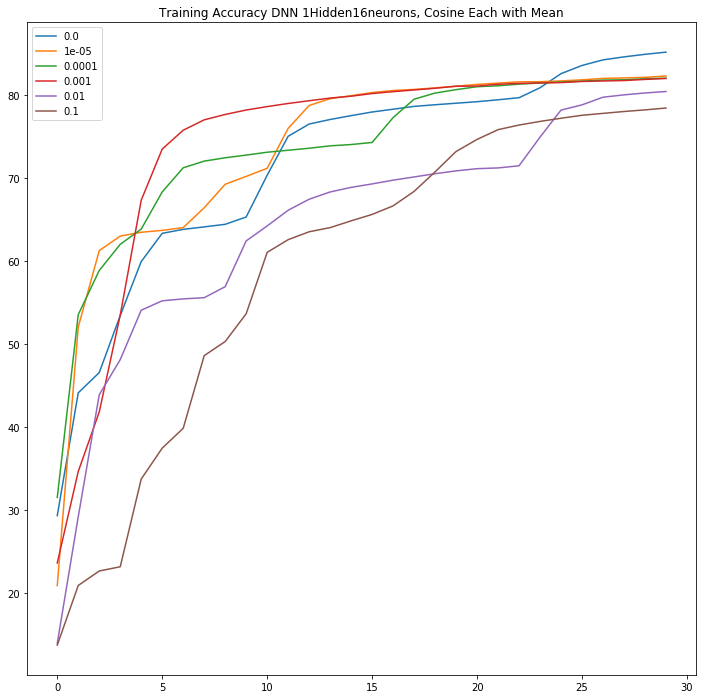

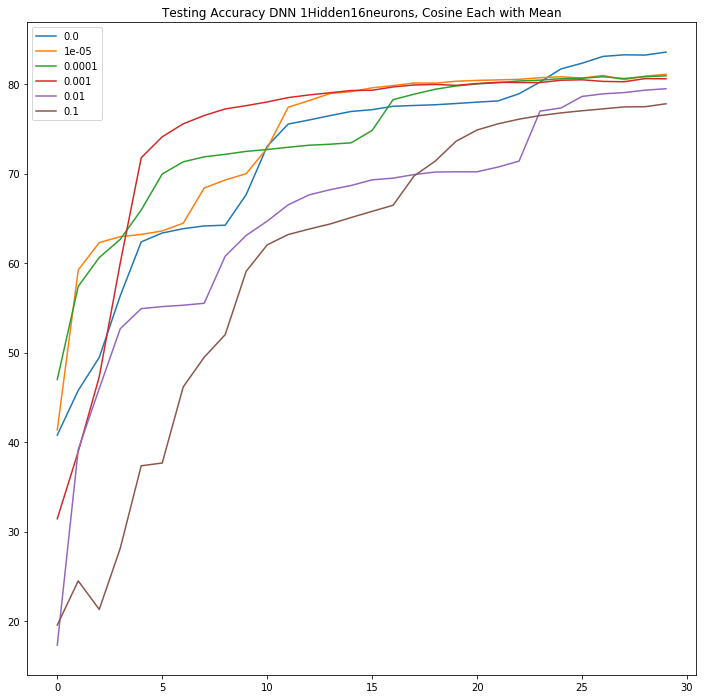

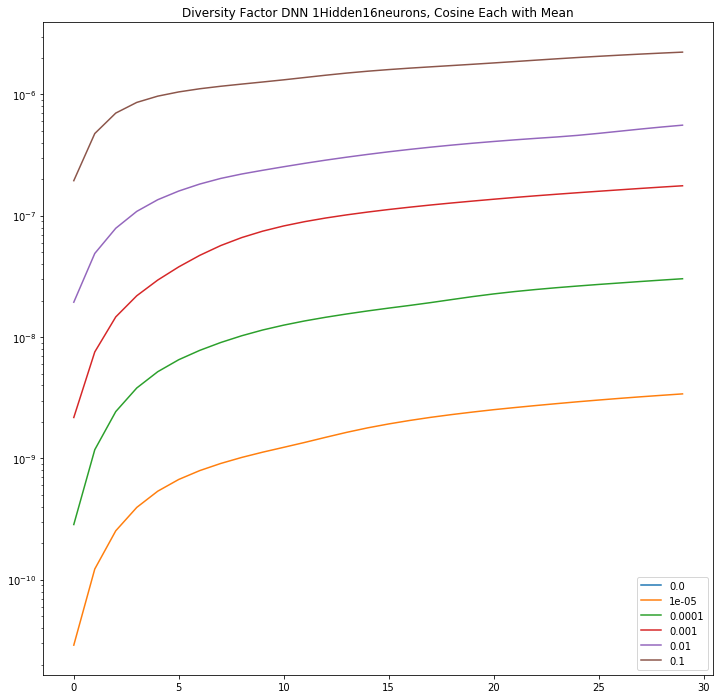

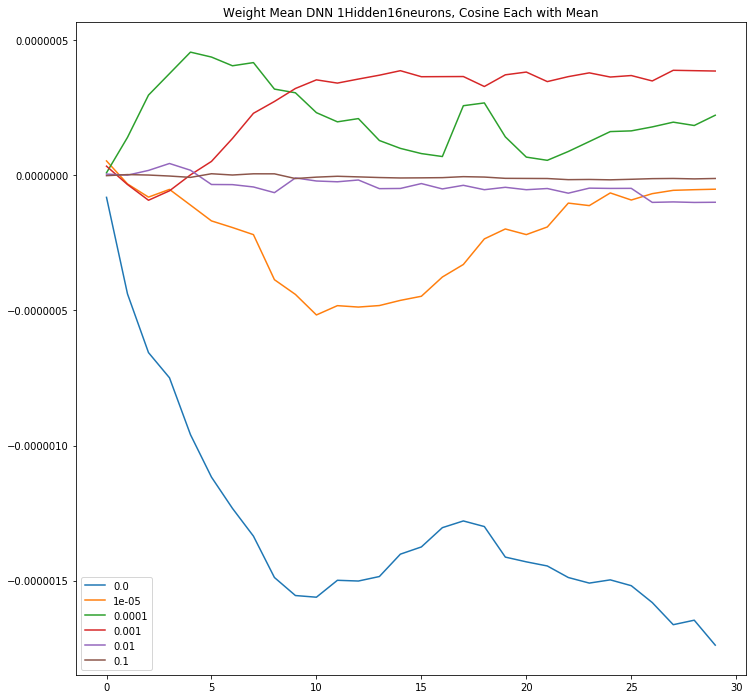

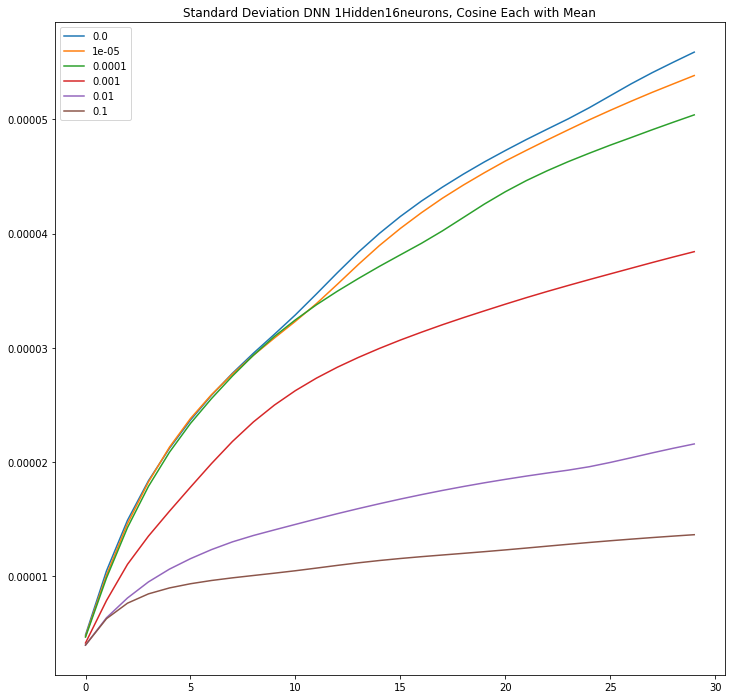

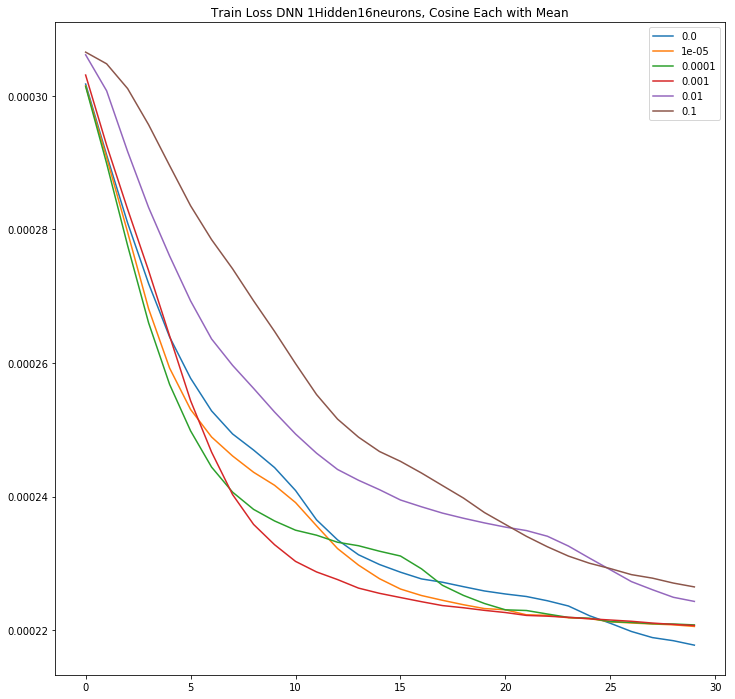

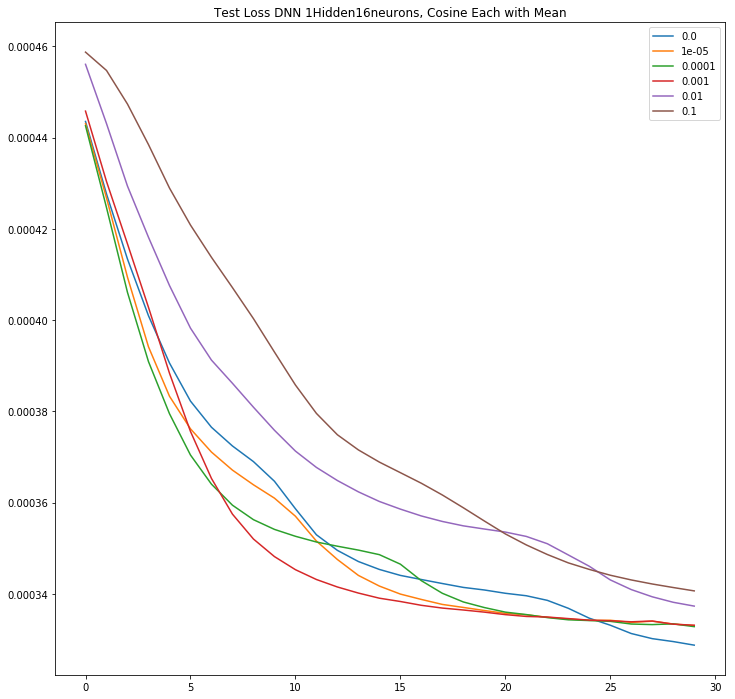

In [221]:
n_pl = 6#number of plots
plt.figure(figsize=(12,12))

for tp in train_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Training Accuracy DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('Training_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
plt.show()

plt.figure(figsize=(12,12))
for tp in test_plots:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Testing Accuracy DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('Testing_Accuracy_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')

plt.figure(figsize=(12,12))
for tp in diversity[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Diversity Factor DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('Diversity_Factor_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in mean_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Weight Mean DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('Weight_Mean_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in std_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Standard Deviation DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('Standard_Deviation_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in loss_train_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Train Loss DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('Train_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

plt.figure(figsize=(12,12))
for tp in loss_test_all_gammas[:n_pl]:
    plt.plot(tp)
    plt.legend([0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1])
plt.title('Test Loss DNN 1Hidden16neurons, Cosine Each with Mean')
plt.savefig('Test_Loss_DNN_1Hidden16neurons_Cosine_Each_with_Mean.png')
#plt.yscale('log') #

# Diversity observation without regularization

In [222]:
gammas = [1.0]#
ns = [16]

all_train = []
all_test = []

for n in ns:

    train_plots = []
    test_plots = []
    
    diversity = []
    
    mean_all_gammas = []
    std_all_gammas = []
    
    loss_train_all_gammas = []
    loss_test_all_gammas = []

    for g in gammas:

        model = Network(n).to(device) #networkSmall NetworkConv
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

        epochs = 100
        gamma = g

        train_acc = []
        test_acc = []
        mean = []
        std = []

        gamma_train = []
        loss_train = []
        loss_test = []

        for epoch in range(1, epochs + 1):
            print('Epoch #: ', epoch)
            trn, m_m, s_m, g_m, l_m = train(model,
                                            device,
                                            train_loader,
                                            optimizer,
                                            epoch,
                                            model.hidden.weight,
                                            gamma=g,
                                            diversity='none'
                                           ) #
            tst, tst_loss = test(model, device, test_loader)
            
            train_acc.append(trn)
            test_acc.append(tst)
  
            mean.append(m_m)
            std.append(s_m)

            gamma_train.append(g_m)
            loss_train.append(l_m)
            loss_test.append(tst_loss)
    
        train_plots.append(train_acc)
        test_plots.append(test_acc)
        
        diversity.append(list(gamma_train))
    
        mean_all_gammas.append(mean)
        std_all_gammas.append(std)

        loss_train_all_gammas.append(loss_train)
        loss_test_all_gammas.append(loss_test)

    all_train.append(train_plots)
    all_test.append(test_plots)

Epoch #:  1

Train set: Average loss: 0.0003, Accuracy: 19983/60000 (33%)

Test set: Average loss: 0.0004, Accuracy: 4936/10000 (49%)

Epoch #:  2

Train set: Average loss: 0.0003, Accuracy: 30811/60000 (51%)

Test set: Average loss: 0.0004, Accuracy: 5431/10000 (54%)

Epoch #:  3

Train set: Average loss: 0.0003, Accuracy: 34630/60000 (58%)

Test set: Average loss: 0.0004, Accuracy: 6073/10000 (61%)

Epoch #:  4

Train set: Average loss: 0.0003, Accuracy: 37130/60000 (62%)

Test set: Average loss: 0.0004, Accuracy: 6236/10000 (62%)

Epoch #:  5

Train set: Average loss: 0.0003, Accuracy: 37855/60000 (63%)

Test set: Average loss: 0.0004, Accuracy: 6301/10000 (63%)

Epoch #:  6

Train set: Average loss: 0.0003, Accuracy: 38137/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6357/10000 (64%)

Epoch #:  7

Train set: Average loss: 0.0002, Accuracy: 38408/60000 (64%)

Test set: Average loss: 0.0004, Accuracy: 6393/10000 (64%)

Epoch #:  8

Train set: Average loss: 0.0002, Accuracy:

Test set: Average loss: 0.0003, Accuracy: 8514/10000 (85%)

Epoch #:  62

Train set: Average loss: 0.0002, Accuracy: 52815/60000 (88%)

Test set: Average loss: 0.0003, Accuracy: 8489/10000 (85%)

Epoch #:  63

Train set: Average loss: 0.0002, Accuracy: 52863/60000 (88%)

Test set: Average loss: 0.0003, Accuracy: 8532/10000 (85%)

Epoch #:  64

Train set: Average loss: 0.0002, Accuracy: 52852/60000 (88%)

Test set: Average loss: 0.0003, Accuracy: 8540/10000 (85%)

Epoch #:  65

Train set: Average loss: 0.0002, Accuracy: 52878/60000 (88%)

Test set: Average loss: 0.0003, Accuracy: 8532/10000 (85%)

Epoch #:  66

Train set: Average loss: 0.0002, Accuracy: 52946/60000 (88%)

Test set: Average loss: 0.0003, Accuracy: 8535/10000 (85%)

Epoch #:  67

Train set: Average loss: 0.0002, Accuracy: 52984/60000 (88%)

Test set: Average loss: 0.0003, Accuracy: 8528/10000 (85%)

Epoch #:  68

Train set: Average loss: 0.0002, Accuracy: 52990/60000 (88%)

Test set: Average loss: 0.0003, Accuracy: 8524/1

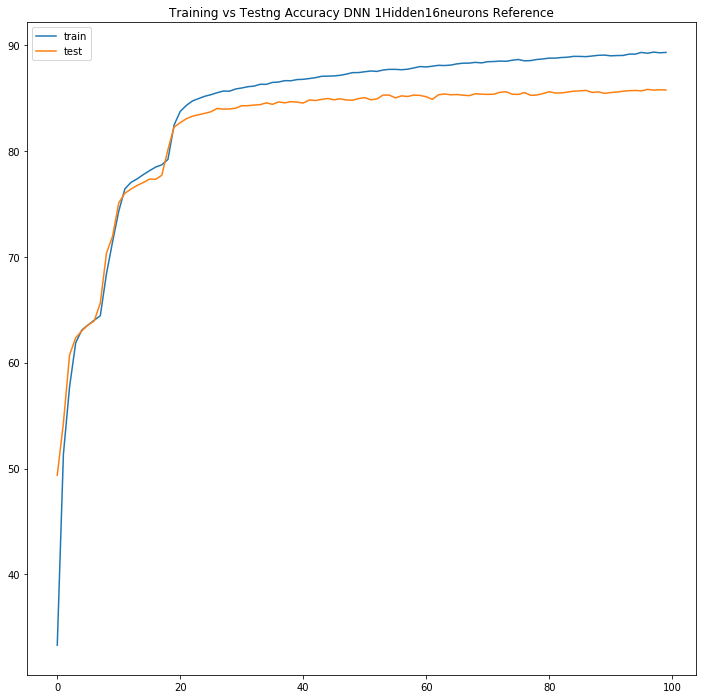

In [225]:
plt.figure(figsize=(12,12))

plt.plot(train_plots[0])
plt.plot(test_plots[0])
plt.legend(['train', 'test'])
plt.title('Training vs Testng Accuracy DNN 1Hidden16neurons Reference')
plt.savefig('Training_Testing_Accuracy_DNN_1Hidden16neurons_Reference.png')
plt.show()

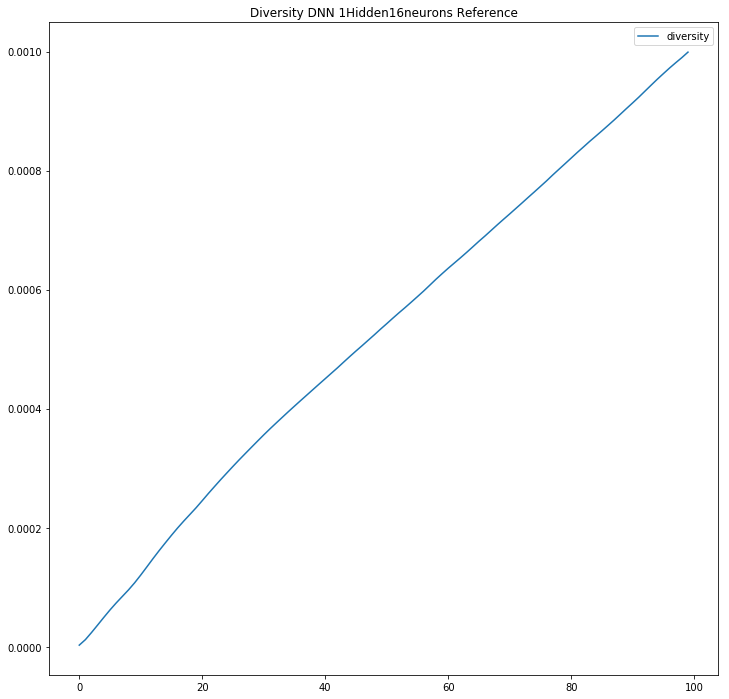

In [226]:
plt.figure(figsize=(12,12))

plt.plot(diversity[0])
plt.legend(['diversity'])
plt.title('Diversity DNN 1Hidden16neurons Reference')
#plt.savefig('Diversity_DNN_1Hidden16neurons_Reference.png')
plt.show()